# Figure 1: Study map

Map of the study area in south-east Queensland and north-east New South Wales. The study area (blue) encompasses the Queensland state capital (Brisbane) as well as several smaller urban areas indicated in the map by points sized according to their population (Australian Bureau of Statistics 2021). The location of the Mount Stapylton radar is also highlighted (red triangle) along with its 135 km range ring highlighted (pink).

## Package imports

In [1]:
additional_package_lib <- "/scratch/w42/ig1052/rlibs"

suppressPackageStartupMessages({
  library(tidyverse)
  library(sf)
  library(ozmaps, lib.loc = additional_package_lib)
  library(paletteer)
  library(ggspatial, lib.loc = additional_package_lib)
  library(scico)
})

## Read in elevation data

In [2]:
# read in elevation data, created in data_cleaning/process_elevation
elev <- read_csv("/g/data/w42/ig1052/bayesian_paper_data/intermediate_data/brisbane_elevation.csv", 
                 show_col_types = FALSE)

## Make the plot

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


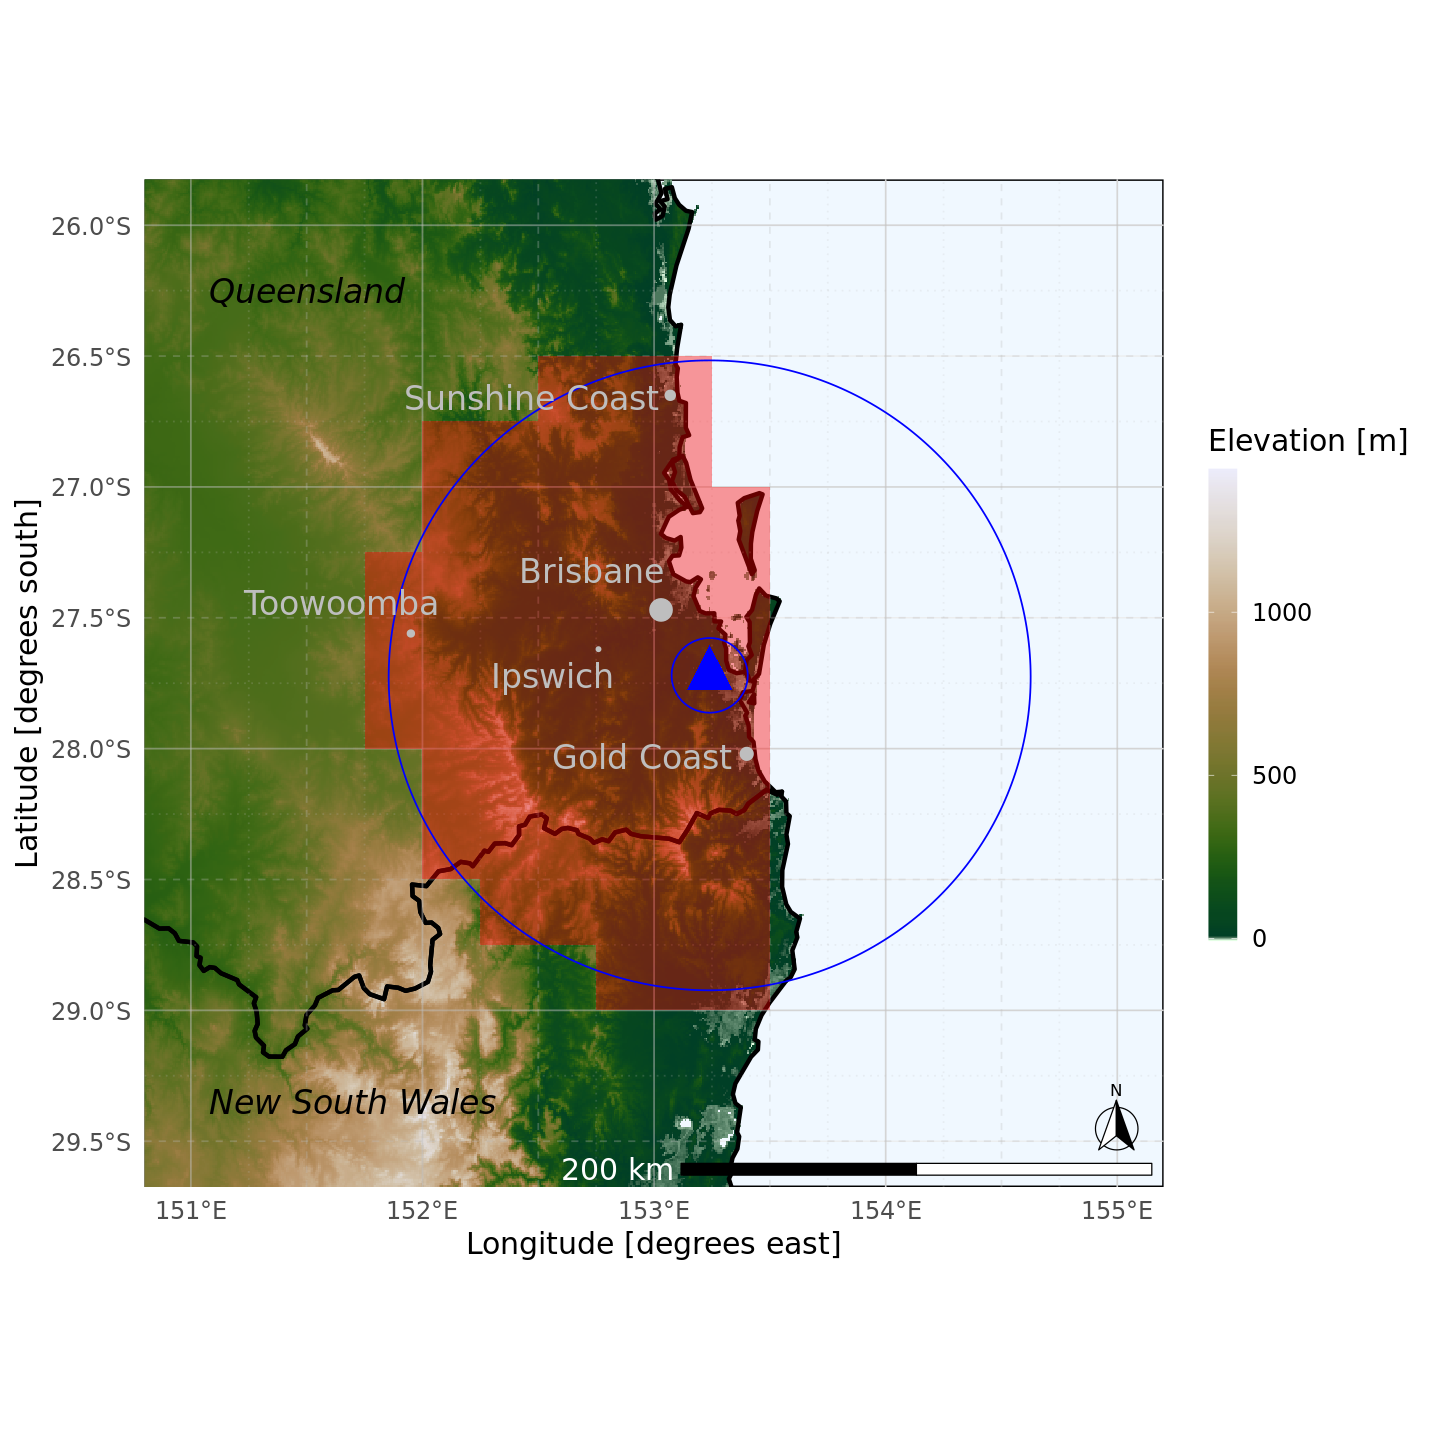

In [3]:
# preparing plot size
options(repr.plot.width = 12, repr.plot.height = 12)

# get all the states data
sf_oz <- ozmap_data("states")

# basic plot with state boundaries and elevation
p <- ggplot() +
  # plot elevation where it is not equal to zero (i.e., land only)
  geom_tile(aes(x = lon, y = lat, fill = elevation), data = elev %>% filter(elevation != 0)) +
  # add state boundaries
  geom_sf(fill = NA, linewidth = 1.25, data = sf_oz, colour = "black") +
  # adjust ratio and axis limits
  coord_sf(xlim = c(151, 155), ylim = c(-29.5, -26)) +
  # colour for elevation
  scale_fill_scico("Elevation [m]", palette = "bukavu", midpoint = 0) +
  # element size
  theme_minimal(base_size = 18) + 
  # add in ocean and re-size legend
  theme(panel.background = element_rect(fill = "aliceblue"),
        legend.key.height = unit(2, "cm"))

# plotting radar range
# getting radar location as australian albers (i.e. meters)
aust_albers_radar <- st_as_sf(tibble(long = 153.24, lat = -27.72), 
                              coords = c("long", "lat"), crs = 4326) %>% 
  st_transform("EPSG:3577") %>%
  st_coordinates

# getting the radius of a certain range
range <- 135 # km
circle_x <- aust_albers_radar[1, "X"] + (range * 1000 * cos(0:360 * pi / 180))
circle_y <- aust_albers_radar[1, "Y"] + (range * 1000 * sin(0:360 * pi / 180))

# getting cone of silence
silence <- 16 # km
silence_x <- aust_albers_radar[1, "X"] + (silence * 1000 * cos(0:360 * pi / 180))
silence_y <- aust_albers_radar[1, "Y"] + (silence * 1000 * sin(0:360 * pi / 180))

# coordinates in m back into degrees for both circles
circle_sf <- st_as_sf(tibble(x = circle_x, y = circle_y), coords = c("x", "y"), 
                      crs = "EPSG:3577") %>% 
  st_transform(4326)
silence_sf <- st_as_sf(tibble(x = silence_x, y = silence_y), coords = c("x", "y"), 
                      crs = "EPSG:3577") %>% 
  st_transform(4326)

# degrees into a tibble for plotting 
circle_tibble <- circle_sf %>% 
  as_tibble %>% mutate(lat = st_coordinates(geometry)[, 2],
                       long = st_coordinates(geometry)[, 1])
silence_tibble <- silence_sf %>% 
  as_tibble %>% mutate(lat = st_coordinates(geometry)[, 2],
                       long = st_coordinates(geometry)[, 1])

# triangle for the radar marker
radar_lat <- -27.72
radar_lon <- 153.24
side_length <- 0.2
x_adj <- side_length / 2
y_adj <- side_length / (2 * sqrt(3))
radar_tri_x <- c(radar_lon - x_adj, radar_lon + x_adj, radar_lon)
radar_tri_y <- c(radar_lat - y_adj, radar_lat - y_adj, radar_lat + (2 * y_adj))
  
# study area
x_study <- c(151.75, 152, 152, 152.25, 152.25, 152.75, 152.75, 153.5, 153.5, 153.25, 153.25, 152.5, 152.5, 152, 152, 151.75, 151.75)
y_study <- c(-28, -28, -28.5, -28.5, -28.75, -28.75, -29, -29, -27, -27, -26.5, -26.5, -26.75, -26.75, -27.25, -27.25, -28)

# city locations and populations
# https://abs.gov.au/census/find-census-data/quickstats/2021/317
city_locations <- tribble(~x, ~y, ~pop,
        153.03, -27.47, 2526238, # Brisbane
        153.40, -28.02, 640778, # Gold Coast
        153.07, -26.65, 342541, # Sunshine Coast
        152.76, -27.62, 115913, # Ipswich
        151.95, -27.56, 162059 # Toowoomba
        )

# plot parameters
text_size <- 7
city_colour <- "gray"
radar_colour <- "blue"

# add annotations to base plot
p +
  # grid lines over the map but under the text 
  # major lines
  geom_vline(xintercept=seq(151, 155, by = 1), color = "grey", alpha = 0.5) +
  geom_hline(yintercept=seq(-29, -26, by = 1), color = "grey", alpha = 0.5) +
  # minor lines
  geom_vline(xintercept=seq(151.5, 154.5, by = 1), color = "grey", alpha = 0.3, 
             linetype = "dashed") +
  geom_hline(yintercept=seq(-29.5, -26.5, by = 1), color = "grey", alpha = 0.3, 
             linetype = "dashed") +
  # grid level
  geom_vline(xintercept=seq(151.25, 154.75, by = 0.5), color = "grey", alpha = 0.2, 
             linetype = "dotted") +
  geom_hline(yintercept=seq(-29.25, -26.25, by = 0.5), color = "grey", alpha = 0.2, 
             linetype = "dotted") +
  # study area
  annotate("polygon", x = x_study, y = y_study, fill = "red", alpha = 0.4) +
  # radar range 
  geom_polygon(aes(x = long, y = lat), color = radar_colour, fill = NA, 
               data = circle_tibble) +
  # cone of silence
  geom_polygon(aes(x = long, y = lat), color = radar_colour, fill = NA, 
               data = silence_tibble) +
  # key cities and locations
  # brisbane
  geom_point(aes(x = x, y = y, size = pop), color = city_colour, data = city_locations) +
  scale_size(guide = "none") +
  annotate("text", x = 153.03 - 0.3, y = -27.47 + 0.15, label = "Brisbane", 
           size = text_size, colour = city_colour) +
  # mount stapylton weather radar
  annotate("polygon", x = radar_tri_x, y = radar_tri_y, fill = radar_colour, size = 3) +
  # gold coast
  annotate("text", x = 153.40 - 0.45, y = -28.02 - 0.01, label = "Gold Coast", 
           size = text_size, colour = city_colour) +
  # sunshine coast
  annotate("text", x = 153.07 - 0.6, y = -26.65 - 0.01, label = "Sunshine Coast",
           size = text_size, colour = city_colour) +
  # ipswich
  annotate("text", x = 152.76 - 0.2, y = -27.62 - 0.1, label = "Ipswich",
           size = text_size, colour = city_colour) +
  # toowoomba
  annotate("text", x = 151.95 - 0.3, y = -27.56 + 0.12, label = "Toowoomba",
           size = text_size, colour = city_colour) +
  # states
  annotate("text", x = 151.5, y = -26.25, label = "Queensland",
           size = text_size, colour = "black", fontface = "italic") +
  annotate("text", x = 151.7, y = -29.35, label = "New South Wales",
           size = text_size, colour = "black", fontface = "italic") +
  # labels
  xlab("Longitude [degrees east]") + 
  ylab("Latitude [degrees south]") +
  annotation_scale(location = "br", width_hint = 0.5, text_cex = 1.5, text_col = "white") +
  annotation_north_arrow(location = "br", which_north = "true", 
                         pad_y = unit(0.25, "in"),
                         style = north_arrow_fancy_orienteering
                         )